In [1]:
%matplotlib ipympl

# Importe
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.linalg import sqrtm

In [2]:
# Funktion Basisklasse
class Function(object):
    def y(self,x):    pass
    def grad(self,x): pass
    def H(self,x):    pass

In [3]:
# Definition einer quadratischen Funktion
A = np.array([[1,0],[0,1]])
b = np.array([0,0])
class f_quad(Function):
    def y(self,x):    return .5*(x[0]*A[0][0]*x[0] + x[0]*A[0][1]*x[1] + x[1]*A[1][0]*x[0] + x[1]*A[1][1]*x[1]) + b[0]*x[0] + b[1]*x[1]
    def grad(self,x): return [b[0],b[1]] + np.dot(A,x)
    def H(self,x):    return A

In [4]:
# Eine nicht-lineare Funktion
class NonLinear(Function):
    def y(self,x):    return 20*np.sin(x[0]) + x[1]**4 
    def grad(self,x): return [ 20*np.cos(x[0]) , 4*x[1]**3 ]
    def H(self,x):    return [ [ -20*np.sin(x[0]) , 0 ] , [ 0 , 12*x[1]**2 ] ] 

In [5]:
# Definition der Branin-Funktion
a=1./8 ; b=10
class Branin(Function):
    def y(self,x):    return (2*x[1]-a*x[0]**2+x[0])**2 + b*np.sin(x[0])
    def grad(self,x): return [2*(2*x[1]-a*x[0]**2+x[0])*(1-a*x[0]) + np.cos(x[0]),
                              4*(2*x[1]-a*x[0]**2+x[0])]
    def H(self,x):    return [[2*(1-a*x[0])**2-4*a*(2*x[1]-a*x[0]**2+x[0]) - b*np.sin(x[0]),
                               4*(1-2*a*x[0])],
                              [4*(1-2*a*x[0]),
                               8]]

In [6]:
# Definition der Rosenbrock-Funktion
a=1.; b=100.
class Rosenbrock(Function):
    def y(self,x):    return (a-x[0])**2 + b*(x[1]-x[0]**2)**2
    def grad(self,x): return [2*(2*x[1]-a*x[0]**2+x[0])*(1-a*x[0]) + np.cos(x[0]),
                              4*(2*x[1]-a*x[0]**2+x[0])]
    def H(self,x):    return [[2*(1-a*x[0])**2-4*a*(2*x[1]-a*x[0]**2+x[0]) - b*np.sin(x[0]),
                               4*(1-2*a*x[0])],
                              [4*(1-2*a*x[0]),
                               8]]

In [7]:
# Gradientenverfahren
def gradDesc(f, start_x, eps, max_iter=1000, alpha = .05):
    x = [[0,0]]
    x[k:=0] = start_x

    while np.linalg.norm(f.grad(x[k]))>eps:
        x.append([0,0])

        # Suchrichtung und Schrittweite bestimmen
        p_k = -np.array(f.grad(x[k]))
        alpha_k = alpha # konstant
        
        # Iterationsschritt
        x[k+1] = x[k] + alpha_k*p_k; k += 1
        if(k>max_iter): break

    # liefere Pfad zurück
    return np.array(x)

In [8]:
# Newton-Verfahren
def newton(f, start_x, eps, max_iter=10, alpha=1):
    x = [[0,0]]
    x[k:=0] = start_x

    while np.linalg.norm(f.grad(x[k]))>eps:
        x.append([0,0])

        # Suchrichtung und Schrittweite bestimmen
        p_k = -np.linalg.solve(f.H(x[k]),f.grad(x[k]))
        alpha_k = alpha # konstant

        # Iterationsschritt
        x[k+1] = x[k] + alpha_k*p_k; k += 1
        if(k>max_iter): break

    # liefere Pfad zurück
    return np.array(x)

In [9]:
# BFGS-Verfahren
def bfgs(f, start_x, eps, max_iter=100, alpha = 1):
    x = [[0,0]]
    x[k:=0] = start_x

    # Startmatrix und erster Gradient
    H_0 = [[1,0],[0,1]]

    H_k = H_0; k = 0
    while np.linalg.norm(f.grad(x[k]))>eps:
        x.append(start_x)

        # Suchrichtung und Schrittweite bestimmen
        p_k = -np.dot(H_k,f.grad(x[k]))
        alpha_k = alpha # konstant
        
        # Iterationsschritt
        x[k+1] = x[k] + alpha_k*p_k; 

        # Hilfsgrößen für Aufdatierung
        y_k = np.array(f.grad(x[k+1])) - np.array(f.grad(x[k]))
        s_k = np.array(x[k+1]) - np.array(x[k])
        
        # H_k+1 für nächste Iteration bestimmen
        s_Hy = s_k - np.dot(H_k,y_k)
        H_k += (np.outer(s_Hy,s_k)+np.outer(s_k,s_Hy))/np.dot(s_k,y_k) - np.dot(s_Hy,y_k)/np.dot(s_k,y_k)**2 * np.outer(s_k,s_k)

        # Update k
        k += 1
        if(k>max_iter): break
    

    # liefere Pfad zurück
    return np.array(x)

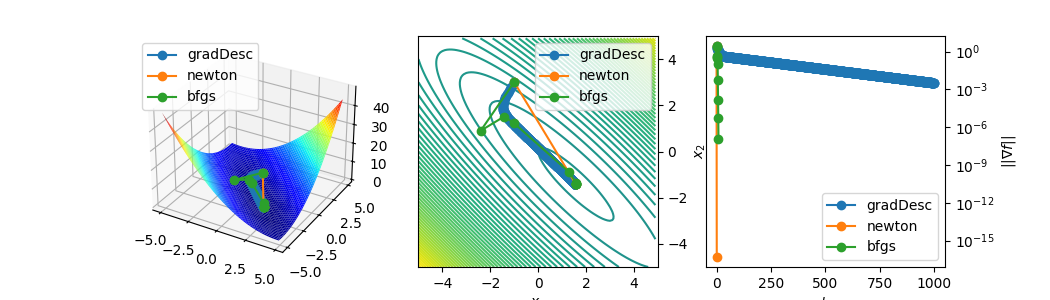

In [10]:
# Wähle Verfahren, die verglichen werden sollen:
verfahren = [gradDesc, newton, bfgs]

# Funktion und Definitionsbereich festlegen
A=np.array([[1,0.9],[0.9,1]]); b = np.array([-.3,0]); f = f_quad(); (x1_min,x1_max,x2_min,x2_max) = (-5,5,-5,5); start_x = [-1,3]
#a=1./8  b=10; f = Branin(); (x1_min,x1_max,x2_min,x2_max) = (-5,5,-5,5); start_x = (-.5,1)
#a=1.; b=100; f = Rosenbrock(); (x1_min,x1_max,x2_min,x2_max) = (-2,2,-1,3); start_x = (-1,1)
#f = NonLinear(); (x1_min,x1_max,x2_min,x2_max) = (-5,5,-5,5); start_x = (-.5,1)

# Grid und Werte für Konturplot berechnen
x1,x2 = np.meshgrid(np.arange(x1_min,x1_max,.1),np.arange(x2_min,x2_max,.1))
lines = np.arange(-50,50,1)
#lines = np.logspace(0,10,num=50) # Log. Höhenlinien
y = f.y((x1,x2))

# Koordinatentransformation
#y = f.y(np.tensordot(sqrtm(np.linalg.inv(A)),(x1,x2),axes=([1],[0])))

# 3d-Function
fig=plt.figure(figsize=(10.5,3))
ax = fig.add_subplot(131,projection='3d')
ax.plot_surface(x1,x2,y,cmap='jet')
for v in verfahren:
    x = v(f,start_x,1e-6)
    plt.plot(x[:,0],x[:,1], "-o",zorder=10, label=v.__name__)
plt.legend()

# Höhenlinien und Pfad
ax=plt.subplot(132)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.contour(x1,x2,y,lines)
for v in verfahren:
    x = v(f,start_x,1e-6)
    #x = np.tensordot(sqrtm(A),x.T,axes=([1],[0])).T # Koord.transformation
    plt.plot(x[:,0],x[:,1], "-o", label=v.__name__)
plt.xlabel('$x_1$');plt.ylabel('$x_2$');
plt.axis([x1_min,x1_max,x2_min,x2_max])
plt.legend()

# Konvergenzrate
ax=plt.subplot(133)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
for v in verfahren:
    x = v(f,start_x,1e-6)
    plt.plot(range(len(x)),list(map(lambda x : norm(f.grad((x))), x)),'-o',label=v.__name__)
plt.xlabel('$k$');plt.ylabel(r'$||\nabla f||$');
plt.yscale('log')
plt.legend()
plt.show()